In [1]:
# Load python packages
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import statsmodels.api as sm

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
# Load R packages
library(edgeR)
library(DESeq2)
library(limma)
library(glmGamPoi)
library(glmmTMB)
library(nebula)
library(fixest)
library(MAST)
library(SingleCellExperiment)
library(scuttle)
library(lme4)

## Load data

In [3]:
# Load data
adata = sc.read_h5ad('data/Kang.h5ad')
adata.obs

,n_genes,n_counts,orig_ident,stim,cluster,Donor
index,,,,,,
CTRL_AAACATACATTTCC.1,878.0,3018.0,CTRL,CTRL,CD14 Mono,SNG-1016
CTRL_AAACATACCAGAAA.1,713.0,2481.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACCTCGCT.1,850.0,3420.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACGGCATT.1,558.0,1582.0,CTRL,CTRL,CD14 Mono,SNG-1015
CTRL_AAACATTGCTTCGC.1,669.0,2536.0,CTRL,CTRL,CD14 Mono,SNG-1256
...,...,...,...,...,...,...
STIM_TCCCGAACTTCGTT.1,702.0,4222.0,STIM,STIM,Eryth,SNG-1015
STIM_TCGGACCTATCAGC.1,502.0,2050.0,STIM,STIM,Eryth,SNG-101
STIM_TGACGCCTCTTGTT.1,899.0,7168.0,STIM,STIM,Eryth,SNG-1015


In [4]:
adata.obs['cluster'].value_counts()

CD14 Mono       4225
CD4 Naive T     2600
CD4 Memory T    1598
B                998
CD16 Mono        974
T activated      767
CD8 T            753
NK               646
DC               463
B activated      355
Mk               289
pDC              108
Eryth             60
Name: cluster, dtype: int64

## Subsample to 5000 cells (randomly)

In [5]:
np.random.seed(0)
cell_idx_random = np.random.binomial(
    n=1,
    p=5000/adata.shape[0],
    size=adata.shape[0]
).astype(bool)
adata_sub = adata[cell_idx_random,:].copy()

## Benchmark preprocessing

1. Select cell-type.
2. Assign random treatment label.
3. Select transcripts with > 10 counts.
4. Output count matrix $\texttt{Y}$, design matrix $\texttt{X}$, size fator $\texttt{sf}$ and membership label.

In [6]:
# label definition: column name in adata.obs
var_celltype = 'cluster'
var_subject = 'Donor'
var_treat_random = 'random_treat'

# assign random treatment label

adata_sub.obs.loc[:, var_treat_random] = np.random.binomial(
    n=1, 
    p=0.5, 
    size=adata_sub.shape[0]
)

# select transcripts with >10 counts
gene_idx_threshold = np.asarray(np.sum(adata_sub.X, axis=0) > 10).ravel()

# Produce Y, X, sf
matrix_count = adata_sub.raw.X[:, gene_idx_threshold].tocsc()
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata_sub.obs[var_treat_random], 
        drop_first=True
    )
).values
cell_sizefactor = np.asarray(np.sum(adata_sub.X, axis=1)).ravel()
cell_sizefactor = cell_sizefactor / cell_sizefactor.mean()
cell_subject = pd.factorize(adata_sub.obs[var_subject])[0]

## Pseudobulk generation

1. Aggregate(=sum) cell counts according to treatment & subject label

In [7]:
# convert psueobulk label to integer
cell_label_pseudobulk, subject_label = pd.factorize(
    adata_sub.obs[var_subject].astype(str) + 
    '_' + 
    adata_sub.obs[var_treat_random].astype(str)
)

# generate summation matrix
spmatrix_subject_sum = sparse.csc_matrix(
    (
        np.ones(adata_sub.shape[0]),
        cell_label_pseudobulk,
        np.arange(adata_sub.shape[0]+1)
    ),
    shape = (
        subject_label.shape[0], 
        adata_sub.shape[0]
    )
)

# generate pseudobulk count, design matrix
matrix_pb_count = spmatrix_subject_sum.dot(
    adata_sub.raw.X
)[:, gene_idx_threshold].T
matrix_pb_design = sm.add_constant(
    pd.get_dummies(
        [x.split('_')[1] for x in subject_label], 
        drop_first=True
    )
).values


## Poisson regression (MLE)

In [38]:
%%time
gene_beta_pr = np.zeros(matrix_count.shape[1])
gene_bse_pr = np.zeros(matrix_count.shape[1])
gene_p_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pr[gene_idx_int] = fit.params[1]
    gene_bse_pr[gene_idx_int] = fit.bse[1]
    gene_p_pr[gene_idx_int] = fit.pvalues[1]

CPU times: user 1h 58min 56s, sys: 2h 16min 31s, total: 4h 15min 28s
Wall time: 5min 20s


## Poisson regression (robust)

In [39]:
%%time
gene_beta_rpr = np.zeros(matrix_count.shape[1])
gene_bse_rpr = np.zeros(matrix_count.shape[1])
gene_p_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_rpr[gene_idx_int] = fit.params[1]
    gene_bse_rpr[gene_idx_int] = fit.bse[1]
    gene_p_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2h 16min 14s, sys: 2h 37min 31s, total: 4h 53min 45s
Wall time: 6min 8s


## Negative-binomial regression (statsmodels)

In [40]:
%%time
gene_beta_nb = np.zeros(matrix_count.shape[1])
gene_bse_nb = np.zeros(matrix_count.shape[1])
gene_p_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_nb[gene_idx_int] = fit.params[1]
    gene_bse_nb[gene_idx_int] = fit.bse[1]
    gene_p_nb[gene_idx_int] = fit.pvalues[1]

CPU times: user 1h 50min 8s, sys: 2h 5min 44s, total: 3h 55min 52s
Wall time: 4min 55s


## Negative-binomial regression (glmGamPoi, robust)

In [41]:
gene_beta_ggp = np.zeros(matrix_count.shape[1])
gene_bse_ggp = np.zeros(matrix_count.shape[1])
gene_p_ggp = np.zeros(matrix_count.shape[1])
matrix_count_T = matrix_count.T.tocsc()

In [87]:
%%time
%%R -i matrix_count_T -i matrix_design -i cell_sizefactor -o gene_beta_ggp -o gene_p_ggp

matrix_count_T <- as(matrix_count_T, "dgCMatrix")
fit <- glmGamPoi::glm_gp(
    matrix_count_T, 
    matrix_design, 
    on_disk=FALSE, 
    size_factors=as.numeric(cell_sizefactor)
    )
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_ggp <- summary(fit)$Beta[,2]
gene_p_ggp <- test$pval

CPU times: user 6min 16s, sys: 23.8 s, total: 6min 40s
Wall time: 1min 58s


## Pseudobulk (edgeR)

In [35]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_edger -o gene_beta_edger
y <- edgeR::DGEList(matrix_pb_count, group=subject_label)
y <- edgeR::calcNormFactors(y)
y <- edgeR::estimateDisp(y, matrix_pb_design)
fit <- edgeR::glmQLFit(y, matrix_pb_design)
qlf <- edgeR::glmQLFTest(fit, coef=2)

gene_p_edger <- qlf$table[,'PValue']
gene_beta_edger <- qlf$table[,'logFC']

CPU times: user 3min 41s, sys: 7.01 s, total: 3min 48s
Wall time: 6.29 s


## Pseudobulk (DESeq2)

In [36]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_deseq2 -o gene_beta_deseq2
dds <- DESeq2::DESeqDataSetFromMatrix(
    matrix_pb_count,
    colData = matrix_pb_design,
    design = ~ 1+V2
)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- DESeq2::estimateDispersions(dds, quiet = TRUE)
dds <- DESeq2::nbinomWaldTest(dds)
        
gene_beta_deseq2 <- results(dds)[,'log2FoldChange']
gene_p_deseq2 <- results(dds)[,'pvalue']

CPU times: user 1min 3s, sys: 2.18 s, total: 1min 5s
Wall time: 10.8 s


## Poisson mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_pmm -o gene_p_pmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_pmm <- rep(0, ncol(matrix_count))
gene_p_pmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=poisson)
    
    
    gene_beta_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

In [12]:
gene_p_pmm

array([0.63848134, 0.69926008, 0.93101127, ..., 0.19790981, 0.24273693,
       0.58570369])

## NB mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_nbmm -o gene_p_nbmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

#gene_beta_nbmm <- rep(0, ncol(matrix_count))
#gene_p_nbmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=nbinom2)
    
    
    gene_beta_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## Result

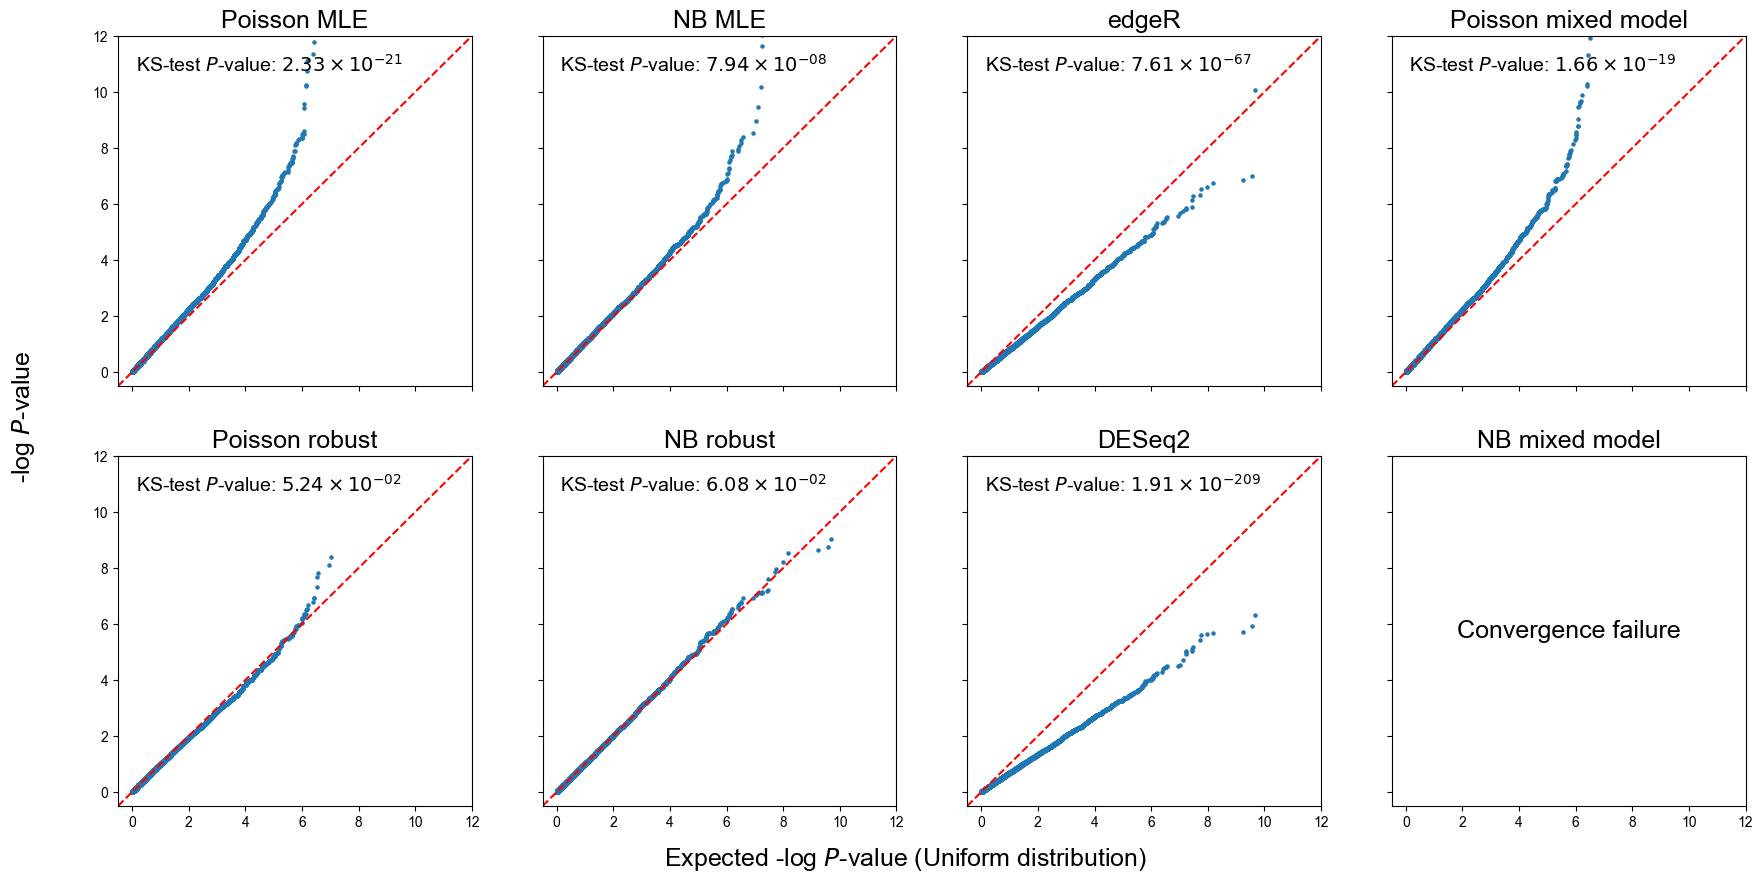

In [83]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_pmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4
    ax[row, col].set_title(label, fontsize=18)
    if label != 'NB mixed model':
        ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
        ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
        
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]

        if np.isnan(pval).sum():
            pval[np.isnan(pval)] = 1
            ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
            base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
            exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
        elif np.isnan(ks_pval):
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
        else:
            base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
            exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
    else:
       ax[row, col].text(0.5, 0.5, 'Convergence failure', fontsize=18, ha='center', va='center', transform=ax[row,col].transAxes) 
    
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

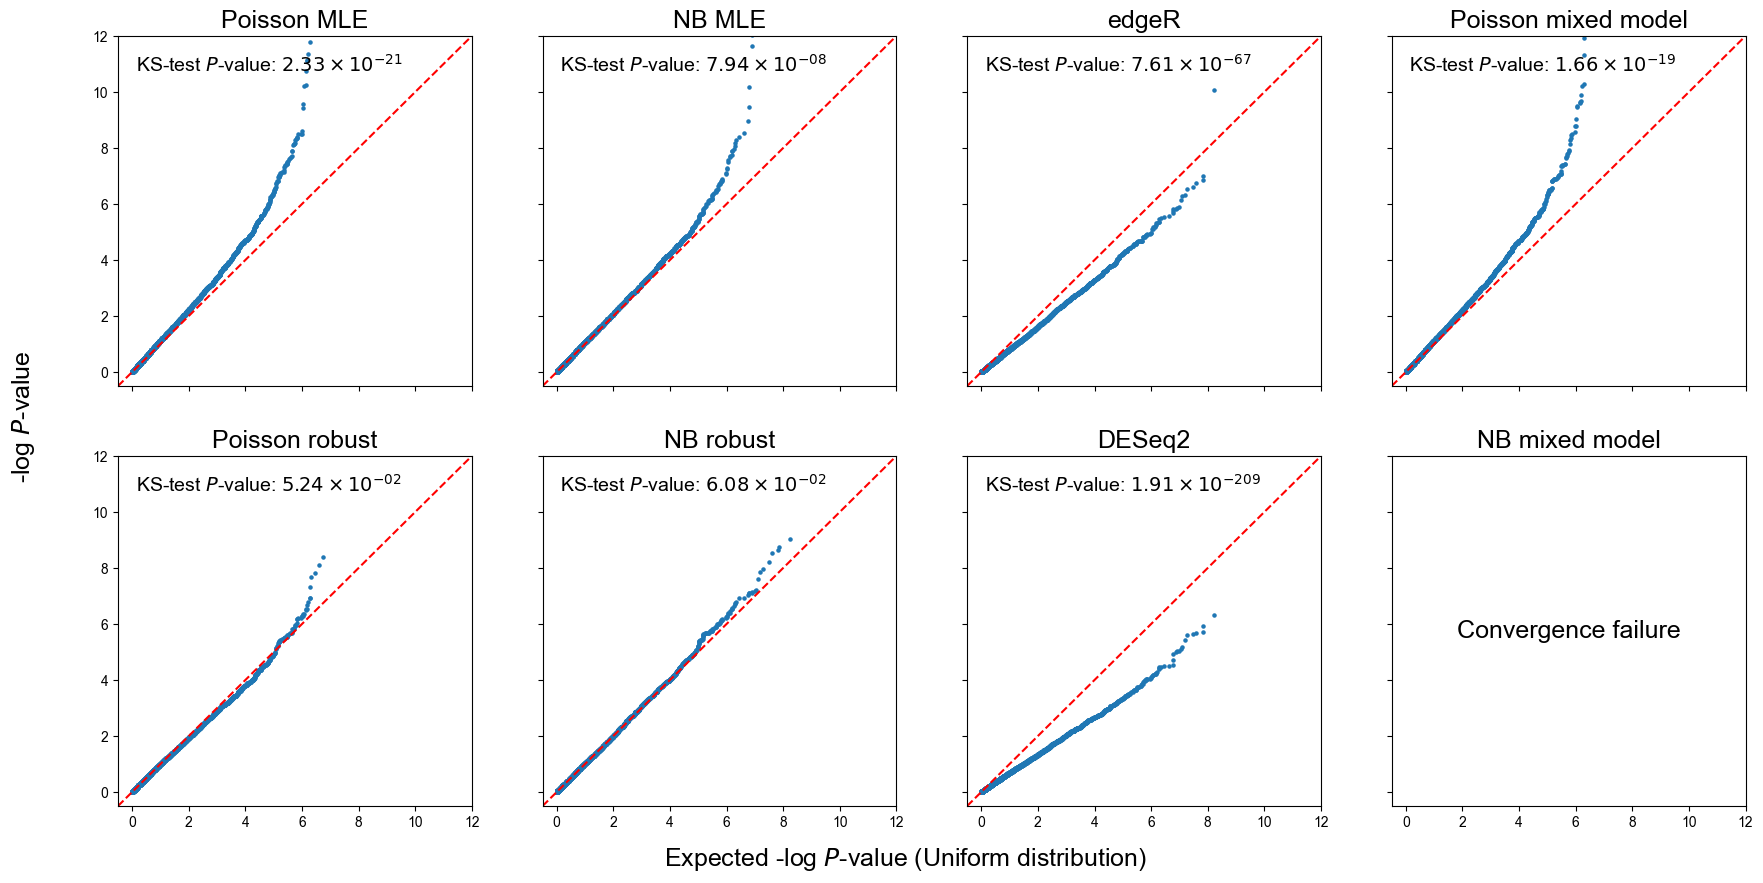

In [22]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=pvals[0].shape)))

# main scatters
#pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_pmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4
    ax[row, col].set_title(label, fontsize=18)
    if label != 'NB mixed model':
        ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
        ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
        
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]

        if np.isnan(pval).sum():
            pval[np.isnan(pval)] = 1
            ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
            base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
            exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
        elif np.isnan(ks_pval):
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
        else:
            base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
            exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
            ax[row,col].text(
                0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
                transform=ax[row,col].transAxes, 
                fontsize=14
            )
    else:
       ax[row, col].text(0.5, 0.5, 'Convergence failure', fontsize=18, ha='center', va='center', transform=ax[row,col].transAxes) 
    
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [23]:
import pickle
 
## Save pickle
with open("pvals_kang_5000.pickle","wb") as fw:
    pickle.dump(pvals, fw)


In [15]:
import pickle

## Load pickle
with open("paper_analysis/pvals_kang_5000.pickle","rb") as fr:
    pvals = pickle.load(fr)

In [17]:
pvals[3] = gene_p_pmm

In [18]:
pvals[3]

array([0.63848134, 0.69926008, 0.93101127, ..., 0.19790981, 0.24273693,
       0.58570369])

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab10_r')


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,5))
fig.subplots_adjust(hspace=0.05)

#labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
labels = ['Poisson MLE', 'Poisson robust', 'NB MLE', 'NB robust', 'edgeR', 'DESeq2', 'Poisson mixed model', 'NB mixed model']
pvalss = [pvals[i] for i in [0,4,1,5,2,6,3,7]]
ks_pvals = []
for i, pval in enumerate(pvalss):
    ks_pval = stats.kstest(pval, stats.uniform.cdf)[1]
    ks_pvals.append(ks_pval)

ks_pvals[-2] = 1.66 * 10 ** (-19)
ks_pvals[-1] = 1
# draw same content
ax1.bar(
    labels, 
    -np.log(ks_pvals),
    color=cmap((range(len(pvals)))),
    edgecolor='black')
ax2.bar(
    labels, 
    -np.log(ks_pvals),
    color=cmap((range(len(pvals)))),
    edgecolor='black')


# hide the spines between ax1 and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.set_xticks([])
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(30, 525)  # outliers only
ax2.set_ylim(0, 24)  # most of the data

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# axis legend
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20, ha='right')
fig.text(0.04, 0.5, 'KS-test -log $\it{P}$-value (lower is better)', fontsize=15, ha='center', rotation=90, va='center')

ax2.text(7, 2, 'NA', ha='center', va='center', fontsize=15)

plt.show()

## Supplementary

In [92]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_pb_ggp -o gene_beta_pb_ggp -o size_factor_pb

fit <- glmGamPoi::glm_gp(
    as.matrix(matrix_pb_count),
    matrix_pb_design,
    on_disk=FALSE
)
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_pb_ggp <- summary(fit)$Beta[,2]
gene_p_pb_ggp <- test$pval
size_factor_pb <- fit$size_factors

CPU times: user 3min 36s, sys: 6.61 s, total: 3min 42s
Wall time: 12.7 s


In [46]:
%%time
gene_beta_pb_pr = np.zeros(matrix_count.shape[1])
gene_bse_pb_pr = np.zeros(matrix_count.shape[1])
gene_p_pb_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_pr[gene_idx_int] = fit.params[1]
    gene_bse_pb_pr[gene_idx_int] = fit.bse[1]
    gene_p_pb_pr[gene_idx_int] = fit.pvalues[1]

CPU times: user 31.9 s, sys: 95.3 ms, total: 32 s
Wall time: 27.1 s


In [47]:
%%time
gene_beta_pb_nb = np.zeros(matrix_count.shape[1])
gene_bse_pb_nb = np.zeros(matrix_count.shape[1])
gene_p_pb_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_nb[gene_idx_int] = fit.params[1]
    gene_bse_pb_nb[gene_idx_int] = fit.bse[1]
    gene_p_pb_nb[gene_idx_int] = fit.pvalues[1]

CPU times: user 28.3 s, sys: 35.6 ms, total: 28.4 s
Wall time: 28.4 s


In [53]:
%%time
gene_beta_pb_rpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_rpr = np.zeros(matrix_count.shape[1])
gene_p_pb_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb) 
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_pb_rpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_rpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 44.2 s, sys: 16.2 s, total: 1min
Wall time: 30.3 s


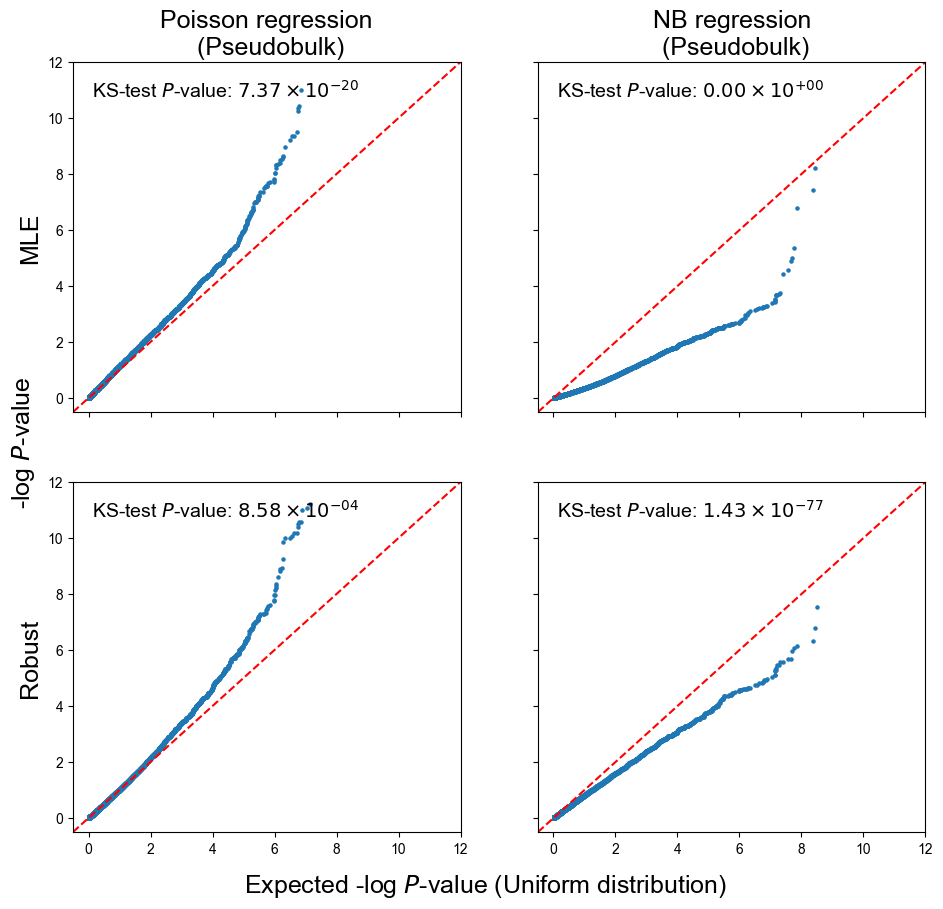

In [91]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 2, figsize=(5*2+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
pvals = [gene_p_pb_pr, gene_p_pb_nb, gene_p_pb_rpr, gene_p_pb_ggp]
labels= ['Poisson regression\n (Pseudobulk)', 'NB regression\n (Pseudobulk)', '', '']
for i, pval, label in zip(range(4),pvals,labels):
    row, col = int(i/2), i%2

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
        
    if col == 0:
        if row == 0:
            ax[row,col].set_ylabel('MLE', fontsize=18)
        else:
            ax[row,col].set_ylabel('Robust', fontsize=18)
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()